<a href="https://colab.research.google.com/github/ABHIRAM199/my_practice/blob/main/NN%2C_Optimizers_for_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN, Optimizers for NNs



**Agenda**
* Introduction
* Rosenbrock's Banana Function
* Optimisation
* What are gradient vectors?
* Gradient Descent
* SGD with Momentum
* RMSProp (Root Mean Square Propagation)
* Adam (Adaptive moment estimation)
* Conclusion

This session will focus on a fundamental aspect of deep learning and machine learning in general: optimization. We will delve into the techniques that enable the transformation of random weights into a highly effective model applicable to various tasks. Specifically, we will implement a number of well-established optimization algorithms designed to identify the minimum value.



In [ ]:
#@title Imports (RUN ME!) { display-mode: "form" }

!pip install tensorflow-gpu==2.0.0-beta0 > /dev/null 2>&1

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
%matplotlib inline

display.clear_output()

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

TensorFlow executing eagerly: True


# Rosenbrock's Banana Function

In the field of machine learning, assessing the efficacy of optimization algorithms and their hyperparameters is crucial. The ultimate goal is to determine their performance on a broad spectrum of real-world problems, which often translates to optimizing a loss function. However, visualizing the behavior of these algorithms can be challenging due to the high dimensionality of the loss landscape associated with even basic neural networks trained on real-world datasets.

To address this issue, we propose using Rosenbrock's Function as a tractable environment for studying the inner workings of optimization algorithms. This function, also known as the banana function due to its visual representation in two dimensions, offers a clear advantage: it accepts a two-dimensional input (x and y) and produces a single scalar output. This characteristic facilitates visualization and simplifies the analysis of optimization algorithms.

\begin{equation}
f(x,y) = (a-x)^2+b\times(y-x^2)^2
\end{equation}Certainly, while the typical values for a and b in Rosenbrock's function are 1 and 100, for this practical exercise we will be using  a = 1 and b = 20. The function's global minimum resides at the point (a, a^2), which translates to (1, 1) in our specific case.

TensorFlow provides a convenient way to define this function. Here's the code for it:

where typical values for $a$ and $b$ are $1$ and $100$, respectively. For this practical we'll use $a = 1$ and $b = 20$. The global minimum of this function is at $(a, a^2)$ or $(1, 1)$ in our case.

We can easily define this function using TensorFlow:

In [ ]:
def rosenbrock_banana(x, y, a=1., b=20.):
  return tf.math.pow(a - x, 2.) + b * tf.math.pow(y - tf.math.pow(x, 2.), 2.)

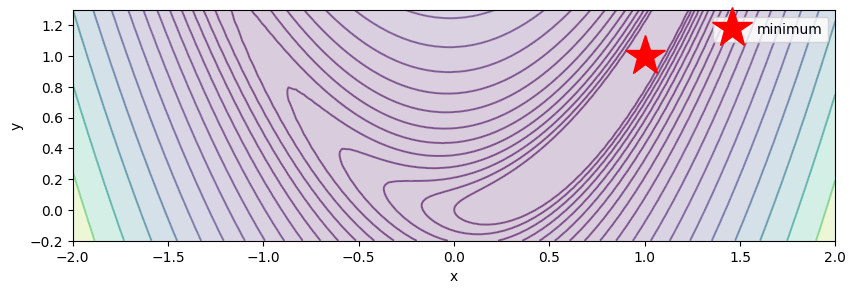

In [ ]:
X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
fig, ax = make_contour_plot(X, Y, Z)

# add a marker to show the minimum
ax.plot(1, 1, 'r*', ms=30, label='minimum')
ax.legend()

fig.show()

# Optimisation

### What is optimisation?

Optimisation is the process of comparing a set of items and selecting the best one, based on some metric. So, we can define an optimisation algorithm as a program (or series of instructions) that try to find the best item when compared to other items using a given method of comparison (or metric).

### How do we use it in machine learning?

Optimisation algorithms are used in machine learning to compare different values for the parameters of a model and to try to find the best one. For the banana function, the optimisation algorithm tries to find the x and y values that lead to the lowest value of the function (here our metric is: "lower values are better"). More practically, optimisation algorithms are used to try to find the best values for our neural network weights and biases. In this case, we use a *loss function* as a metric and try to select the weights and biases that lead to the lowest loss function value. But, we don't need to worry about that yet. First, we need to build up some tools that will let us do this.

**Note:** You may be wondering why we need special optimisation algorithms at all. For example, the minimum for the banana function above can be computed analytically. And indeed, for many optimisation problems, including some problems in machine learning such as linear regression, it is easy to compute solutions analytically. So why are we spending a whole practical on this topic? The reason is **computational complexity**. There are a huge number of problems, including optimising deep neural networks, for which we cannot find an analytical solution in a reasonable amount of time. In these cases, we need to find approximate solutions to our optimisation problems, which is what we will be looking at in this practical.

# What are gradient vectors?

*Note: feel free to skip this if you already understand what a gradient vector represents.*

Let's start with a scalar function $f$, which maps the input $x$ to the output $y$: $$y = {f(x)}$$

Here, $f$ could be a polynomial, exponential, or whatever your favorite kind of mathematical function is.

Let's now  _approximate_ the function $ f$ around a particular point $x_0$ with a straight-line function $ {d f}$:

$${d f(x)} = f(x_0) + {f'(x_0)}(x - x_0)$$

**Reminder:** the equation for a straight-line function can be given as: $y = m x + c$, where $m$ is the slope of the line and $c$ raises the function. If we want the function to go through a given point $(x_0, y_0)$, then we can change the equation to the following: $y = m (x - x_0) + y_0$. Notice, we just shifted the line along the $x$-axis and made sure the function is raised by $y_0$.

As the picture above shows, we can use the derivative $f' = \frac{dy}{dx}$ to construct the best linear approximation to a function $f$ around a specific point $x_0$. Specifically, the derivative gives us the _slope_. If the function above was horizontal at $x_0$, you can see that the gradient ${f'(x_0)}$ would be zero.

Notice the _crucial_ fact that the gradient ${f'(x_0)}$ points in the _direction_ in which ${f(x)}$ _increases_, and the magnitude tells us _how quickly_ it increases. Here, the gradient is positive, which tells us the function is increasing to the *right*, and the large magnitude tells us it is increasing relatively quickly.

#### What did we just do?

In the context of optimization, we previously approximated a general function f(x) using a straight line. This linearization provided valuable insights:

Directional Change: The slope of the tangent line at a point x₀, denoted by f'(x₀), indicates the direction of f's increase at that point. In other words, it reveals the direction in which we should adjust x₀ to achieve a higher function value f(x).
Step Size: The slope f'(x₀) also provides an estimate for the magnitude of change required to x₀. This helps determine how far we should move in the direction indicated by the slope.
These concepts are fundamental to optimization because:

Function as Comparison Tool: We can leverage the function f(x) to compare different elements or "items" under consideration. By evaluating f(x) for each item, we can determine which one possesses a more favorable value.
Derivative as Guide: The derivative f'(x₀) acts as a guide, pointing us in the direction of improvement. By iteratively adjusting x₀ based on f'(x₀), we can progressively find items with better function values compared to the initial x₀.
In essence, f(x) serves as our performance metric, while x₀ represents the current state of an "item" we aim to optimize. We exploit the direction provided by f'(x₀) to move towards a superior state with a higher f(x) value.

Below is an interactive version of the graphic. Play around with $x_0$ and build an intuition of how the gradient ${f'(x_0)}$ changes with the slope of the function ${f(x)}$.

In [ ]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)
def f(x):
  return -np.cos(x)

def tangent_f(x):
  return np.sin(x)

def df(x, x_0):
  return tangent_f(x_0) * (x - x_0) + f(x_0)

def perpindicular_unit_f(x_0):
  slope_f = tangent_f(x_0)
  y_0 = f(x_0)

  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f

  return [[x_0, x_1], [y_0, y_1]]

def interactive_gradient_visual(x_0):
  # change the fontsize for better visibility
  init_size = plt.rcParams["font.size"] # store initial font size
  plt.rcParams.update({'font.size': 22}) # update the size

  plt.figure(figsize=(12, 8))

  x = np.linspace(-np.pi, 2 * np.pi)
  f_x = f(x)

  # plot f(x)
  plt.plot(x, f_x, label=r"$f(x)$", color="green")

  # add a point showing where x_0 falls on f(x)
  plt.plot(x_0, f(x_0), marker="o", color="black")

  # plot the tangent line to f(x) at x_0
  plt.plot(x, df(x, x_0), linestyle="--", color="cornflowerblue", label=r"$df(x)$")

  # plot the normal vector to the tangent
  perp_unit_vector = perpindicular_unit_f(x_0)
  plt.plot(perp_unit_vector[0], perp_unit_vector[1], color="dimgray")

  # drop a vertical line from x_0
  plt.plot([x_0, x_0], [f(x_0), -3.1], color="silver")

  # plot the positive direction of change vector
  [[x_0, x_1], [y_0, y_1]] = perp_unit_vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="red", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="red", label=r"$f'(x_0)$")

  plt.legend(loc="upper left")
  plt.xlim(-3.1, 6.2)
  plt.ylim(-3.1, 3.1)
  plt.xlabel(r"$x_0$")
  plt.show()

  # reset to initial font size
  plt.rcParams.update({'font.size': init_size})

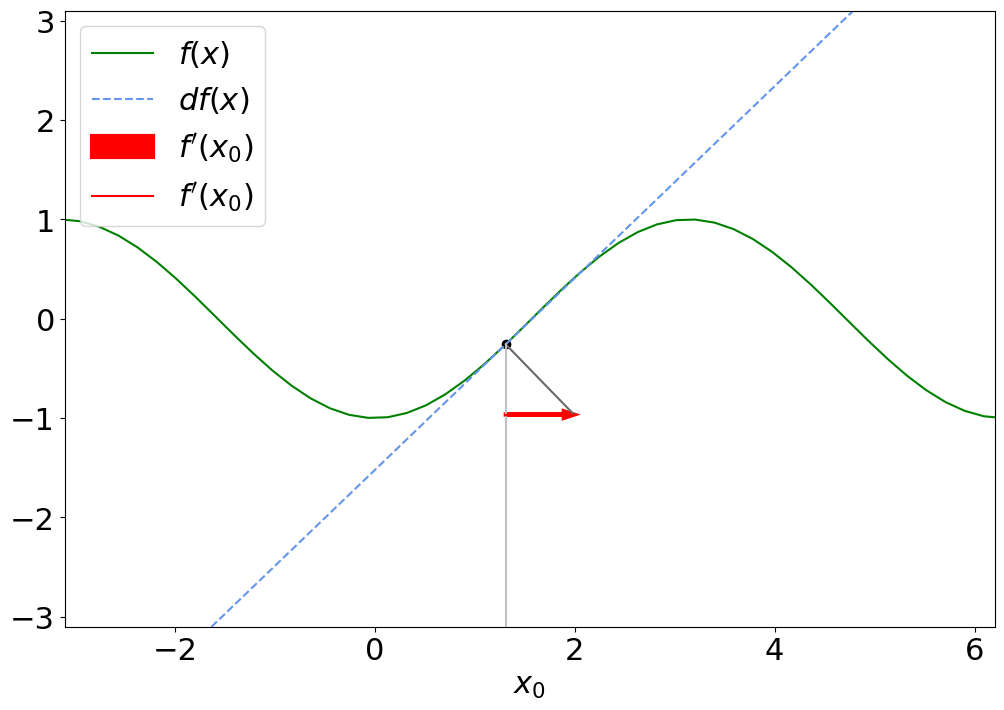

In [ ]:
#@title Double click to unhide/hide the code {run: "auto"}
x_0 = 1.1 #@param {type:"slider", min:-3.1, max:6.2, step:0.01}

interactive_gradient_visual(x_0)

Again, notice how the gradient ${f'(x_0)}$ (the red arrow) always points in the direction where the funciton ${f(x)}$ is increasing. Also notice how the magnitude (length of the arrow) of the gradient ${f'(x_0)}$ increases when the slope increases.

## Moving to higher dimensions

The same principle extends seamlessly to functions with vector-valued inputs. The underlying concept remains consistent, but the mathematical operations require slight adjustments:

Scalar vs. Vector Derivatives: We transition from the scalar derivative f'(x₀) used for scalar-valued functions to the vector gradient ∇f(x₀). The gradient, denoted by the upside-down delta symbol (nabla), captures the directional change of the function f at point x₀ across all its input dimensions.
Scalar Multiplication vs. Dot Product: The scalar multiplication between the scalar derivative f'(x₀) and the scalar difference (x - x₀) is replaced by the dot product between the vector gradient ∇f(x₀) and the vector difference (x - x₀). The dot product calculates a scalar quantity representing the projection of one vector onto another.
In essence, while the core idea of utilizing the derivative to guide optimization remains, the mathematical representation adapts to handle vector-valued functions. We leverage the gradient to capture the direction of change and employ the dot product to determine the appropriate step size in this more general scenario.

<center>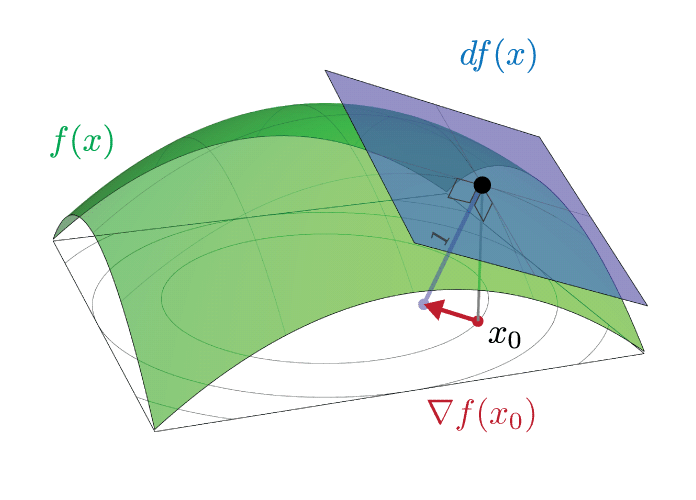</center>


The accompanying illustration depicts the vector gradient ∇f(x₀) as the slope of a tangent plane approximating the surface of function f near point x₀. This slope possesses two key properties:

**Direction of Steepest Ascent:** The gradient points in the direction of steepest ascent, which can be visualized as "the uphill direction." It indicates the direction along which the function f increases most rapidly at point x₀.
**Magnitude and Flatness:** The magnitude of the gradient reflects the steepness of the tangent plane. A zero gradient signifies a flat plane, implying minimal change in the function's value in any direction around x₀.

**Important Note:** It's crucial to recognize that the gradient points towards the direction of increase for the function. However, in the context of gradient descent (which we'll discuss next), our objective is to move in the direction of decrease for the loss function. To achieve this, we simply update our position based on the negative of the gradient. This essentially flips the direction and allows us to navigate towards the function's minimum point.

# Gradient Descent

Gradient descent is the simplest of training algorithms commonly used in deep learning. However, it gives excellent results in many cases, and also forms the basis for many other powerful optimization methods - such as Momentum, RMSProp, and Adam - which we will look at later in this practical. Mathematically we can describe gradient descent as follows:

\begin{equation}
\mathbf{θ}= \mathbf{θ} −\eta \times \nabla_\mathbf{θ} J(\mathbf{θ})
\end{equation}

where $\mathbf{θ}$ are the parameters of the model, $\eta$ (eta) is the learning rate, $J(\mathbf{θ})$ is the loss (also called $\mathcal{L}$), and $\nabla_\theta J(\mathbf{θ})$ is the **gradient** of the loss with respect to the parameters (similarl to ${\nabla f(\mathbf x_0)}$ in the example above). This equation tells us that to update each of the parameters, we scale the gradient for each parameter by the learning rate and subtract it from the corresponding parameter. Or, in pseudo-code:

```
for each epoch:
  grad = calc_grad(loss_func, data, params)  # Calculate gradient of loss wrt parameters
  params = params - learning_rate * grad
```

You might have noticed that we are sweeping a lot of critical details under the rug here! Firstly we are assuming that we can easily calculate the gradients using some `calc_grad` function, and secondly, we are ignoring the issue of batch size (the number of training data points we use to calculate an estimate of the gradient).

Our explanation has thus far glossed over some significant details. Firstly, we've assumed the existence of a convenient calc_grad function for calculating gradients. Secondly, we've neglected the concept of batch size, which influences how we estimate the gradient.

Fortunately, TensorFlow addresses the first point through automatic differentiation (AD). AD streamlines gradient calculation, making it akin to calling a calc_grad function. This eliminates the need to delve into the specifics of manual gradient computation or algorithms like backpropagation. If you're interested in the inner workings of AD, the "Build your own TensorFlow" tutorial is a valuable resource.

In practice, batch size serves as a hyperparameter that can be optimized. Here's a breakdown of the three common scenarios:

1. Batch Gradient Descent (BGD):

Batch size (n) equals the total number of training examples.
The entire dataset is used to compute the gradient at each step, resulting in the most accurate gradient estimate.
When the learning rate is appropriate, BGD offers convergence guarantees:
Global minimum for convex optimization surfaces.
Local minimum for non-convex surfaces (assuming no saddle points).
However, BGD presents limitations:
Incompatibility with online learning (receiving new examples during training).
Potential slowness for large datasets due to extensive computations at each step.
Exercise: Explore the consequences of using BGD with an excessively high learning rate on a convex optimization surface. Will it diverge or locate a local minimum? (Hint: Consider creating a diagram to visualize the scenario.)

2. Stochastic Gradient Descent (SGD):

Batch size is 1.
Only a single data point contributes to the gradient estimate, leading to a noisy result.
SGD doesn't guarantee finding a minimum (local or global).
Despite this, SGD demonstrates effectiveness in practice and facilitates online learning.
The inherent noise in the gradient estimate acts as a form of regularization, potentially mitigating overfitting.
Additionally, SGD requires less memory compared to BGD due to the single-example approach. Memory limitations can be a significant concern with BGD.
3. Mini-batch Gradient Descent:

Batch size (m) falls between 1 and the total number of training examples (n).
m examples are used to estimate the gradient.
This approach offers a balance between BGD and SGD:
Maintains some noise in the gradient estimate.
Enables memory optimization by adjusting the batch size.
Significantly reduces the variance of the gradient estimate, leading to improved convergence towards local or global minima.





### Optional extra reading: choosing a batch size

Here's a formal paraphrase of the passage about choosing a batch size:

**Selecting an Appropriate Batch Size**

A crucial question arises: how to determine the optimal batch size for a specific problem?

One strategy involves utilizing the largest feasible batch size. This preference stems from the efficiency gains associated with larger batch sizes. Modern computing systems, particularly those equipped with GPUs, are architected for parallel processing. Consequently, a larger batch size allows for better hardware utilization, leading to faster model training.

In practice, the common approach is to select the biggest batch size that can be accommodated by the available memory.

According to some research, employing a larger batch size facilitates the use of a higher learning rate, which translates to expedited model training. However, excessively high learning rates can hinder convergence to a minimum value. Therefore, effective tuning of the batch size remains essential.

For a more in-depth exploration of these concepts, you can refer to the provided blog post and research paper. The paper delves specifically into strategies for selecting various hyperparameters crucial for deep learning optimization.


Let's look at the one dimensional straight-line aproximation example from above and see how the batch size affects the calculated gradient. In the plot below, we see the function ${f(x)}$, the true tangent line ${df(x)}$, the true gradient ${\tilde{f'}(x_0)}$, the calculated tangent line ${\tilde{df}(x)}$ and the calculated gradient ${\tilde{f'}(x_0)}$. In this case, we get the calculated tangent line ${\tilde{df}(x)}$ and gradient ${\tilde{f'}(x_0)}$ by using *batch_size* number of datapoints to calculate an estimate.

Change the values for $x_0$ and *batch_size* and see what you can learn.

In [ ]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)
def f(x):
  return -np.cos(x)

def tangent_f(x):
  return np.sin(x)

def df(x, x_0):
  return tangent_f(x_0) * (x - x_0) + f(x_0)

def perpindicular_unit_f(x_0):
  slope_f = tangent_f(x_0)
  y_0 = f(x_0)

  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f

  return [[x_0, x_1], [y_0, y_1]]

def noisy_df(x, x_0, noisy_x_0):
  return tangent_f(noisy_x_0) * (x - x_0) + f(x_0)

def noisy_perpindicular_unit_f(x_0, noisy_x_0):
  slope_f = tangent_f(noisy_x_0)
  y_0 = f(x_0)

  x_1 = slope_f / np.sqrt(2) + x_0
  y_1 = -x_1 / slope_f + y_0 + x_0 / slope_f

  return [[x_0, x_1], [y_0, y_1]]

def interactive_noisy_gradient_visual(x_0, noisy_x_0):
  # change the fontsize for better visibility
  init_size = plt.rcParams["font.size"] # store initial font size
  plt.rcParams.update({'font.size': 22}) # update the size

  plt.figure(figsize=(12, 8))

  x = np.linspace(-np.pi, 2 * np.pi)
  f_x = f(x)
  y_0 = f(x_0)

  # plot f(x)
  plt.plot(x, f_x, label=r"$f(x)$", color="green")

  # add a point showing where x_0 falls on f(x)
  plt.plot(x_0, f(x_0), marker="o", color="black")

  # plot the tangent line to f(x) at x_0
  plt.plot(x, df(x, x_0), linestyle="--", color="cornflowerblue", label=r"$df(x)$")

  # drop a vertical line from x_0
  plt.plot([x_0, x_0], [f(x_0), -3.1], color="silver")

  # plot the noisy tangent line to f(x) at x_0
  plt.plot(x, noisy_df(x, x_0, noisy_x_0), linestyle="--", color="red", label=r"$\widetilde{df}(x)$")

  # plot the normal vector to the tangent
  [[x_0, x_1], [y_0, y_1]] = perpindicular_unit_f(x_0)
  plt.plot([x_0, x_1], [y_0, y_1], color="dimgray")

  # plot the positive direction of change vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="blue", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="blue", label=r"$f'(x_0)$")

  # plot the noisy normal vector to the tangent
  [[noisy_x_0, x_1], [noisy_y_0, y_1]] = noisy_perpindicular_unit_f(x_0, noisy_x_0)
  plt.plot([x_0, x_1], [y_0, y_1], color="dimgray")

  # plot the noisy positive direction of change vector
  dx = x_1 - x_0
  dy = 0 # y_1 - y_1
  arrow = plt.arrow(
      x_0, y_1, dx, dy,
      color="red", label=r"$f'(x_0)$",
      lw=3, head_width=np.abs(x_1 - x_0)/10, length_includes_head=True
  )
  plt.plot([x_0, x_1], [y_1, y_1], color="red", label=r"$\widetilde{f'}(x_0)$")


  plt.legend(loc="upper left")
  plt.xlim(-3.1, 6.2)
  plt.ylim(-3.1, 3.1)
  plt.xlabel(r"$x_0$")
  plt.show()

  # reset to initial font size
  plt.rcParams.update({'font.size': init_size})

def interactive_batch_size_visual(x_0, batch_size):
  np.random.seed(0)
  noisy_x_0 = x_0 + np.mean(np.random.normal(loc=0, scale=0.5, size=batch_size))
  interactive_noisy_gradient_visual(x_0, noisy_x_0)

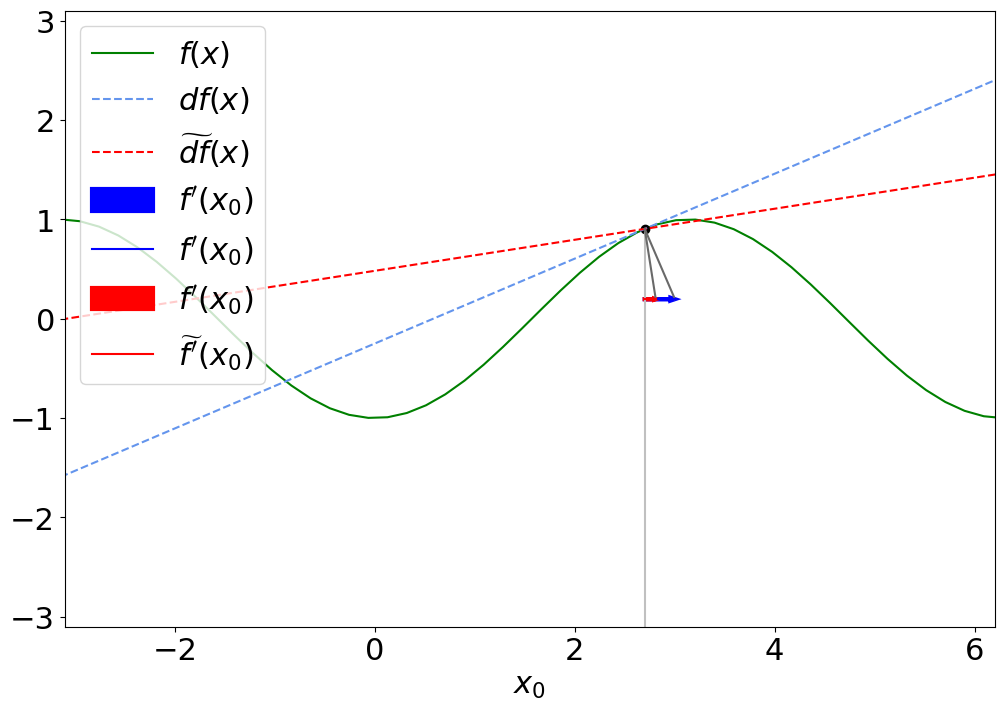

In [ ]:
#@title Double click to unhide/hide the code {run: "auto"}
x_0 = 2.7 #@param {type:"slider", min:-3.1, max:6.2, step:0.01}
batch_size = 20 #@param {type:"slider", min:1, max:256, step:1}

interactive_batch_size_visual(x_0, batch_size)

**Exercise:** What are the general relationships you notice between the accuracy of the calculated gradient ${\tilde{f'}(x_0)}$ and (a) the batch size and (b) the funciton ${f(x)}$?

### Implementing SGD

SGD is incredibly simple to implement, and as you'll see later can perform very well!

In [ ]:
def SGD_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01
  # SGD doesn't have any state, however, the algorithms
  # we will look at later do!
  for param, grad in zip(params, grads):
    param.assign_sub(hyper_params['lr'] * grad)

And now we can visualize each step of the SGD optimization:

**Exercise:** Take a look at the hidden code below and make sure that you understand it. Do you see how the code relates to the pseudo-code and equation above? For example, where do you find `calc_grad`? Once you understand the code, you should hide it again to make it easier to change the sliders and see the results.

In [ ]:
#@title Helper functions (RUN ME) (double click to unhide/hide the code)

def optimize_banana(update_func, params, states, hyper_params):
  # plot the loss surface, minimum value and starting point
  X, Y, Z = gen_2d_loss_surface(rosenbrock_banana)
  fig, ax = make_contour_plot(X, Y, Z)
  ax.plot(1, 1, 'r*', ms=30, label='minimum')
  ax.plot(start_x, start_y, 'b*', ms=20, label='start')

  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      # we are trying to minimize the output of the 🍌 func
      loss = rosenbrock_banana(x, y)
    # calculate the gradients of the loss with respect to the params
    grads = tape.gradient(loss, params)

    # save the old x and y values for the plot
    old_x = params[0].numpy()
    old_y = params[1].numpy()

    # update the parameters using SGD
    update_func(params, grads, states, hyper_params)

    # plot the change in x and y for each update step
    ax.annotate('', xy=(x.numpy(), y.numpy()),
                xytext=(old_x, old_y),
              arrowprops={'arrowstyle': '->', 'color': 'k', 'lw': 1},
                   va='center', ha='center')

  ax.plot(x.numpy(), y.numpy(), 'g*', ms=20, label='end')
  ax.legend()

  fig.show()

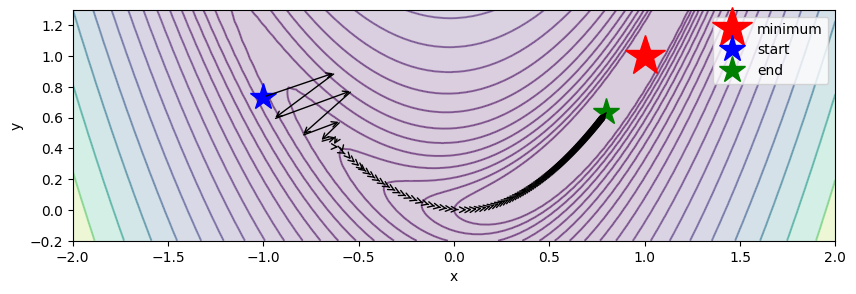

In [ ]:
#@title Double click to unhide/hide the code {run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.015 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 150 #@param {type:"slider", min:1, max:150, step:1}

x = tf.Variable(start_x, dtype='float32')
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
states = []
hyper_params = {"lr": learning_rate}

optimize_banana(SGD_update, params, states, hyper_params)

**Partner Exercise:** Tweak the starting position (x and y), as well as the learning rate and the number of epochs. See if you can get to the global minimum. What do you notice about the behaviour of SGD in the Rosenbrock's Banana Function valley?

## SGD with Momentum

Hopefully, you've noticed a bit of an issue with SGD. When the gradient is small the changes to the parameters become very small and progress towards the minimum is very slow. One solution to this problem is to add a momentum term to our optimization step:

\begin{align}
\Delta \mathbf{θ} &= \gamma \Delta \mathbf{θ} + \eta \nabla_\mathbf{θ} J(\mathbf{θ}) \\
\mathbf{θ} &= \mathbf{θ} − \Delta \mathbf{θ}
\end{align}

where $\Delta \mathbf{θ}$ is the change in parameters $\mathbf{θ}$ at each step and is made up of a mixture between the gradients at a given step and the change from the previous step. $\gamma$ (gamma) is called the *momentum* term, and $\eta$ is called the learning rate, as before.

The reason that this method is called *momentum* is that we can compare it to SGD as follows:

> Gradient descent is a person walking down a hill. They follow the steepest path downwards; their progress is slow, but steady. Momentum is a heavy ball rolling down the same hill. The added inertia acts both as a smoother and an accelerator, dampening oscillations and causing it to barrel through narrow valleys, small humps and local minima.

In other words, **the momentum term speeds up optimisation if the direction of change stays more or less the same and reduces oscillations when the direction of change goes back and forth**.

We can also describe momentum with some simple pseudo-code:

```
change = 0
for each epoch:
  grad = calc_grad(loss_func, data, params)
  change = momentum * change + learning_rate * grad
  params = params - change
```

### Implementing Momentum

In [ ]:
def momentum_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01, momentum=0.9
  changes = states['changes']
  for param, grad in zip(params, grads):
    changes[param].assign(hyper_params['momentum'] * changes[param] +
                          hyper_params['lr'] * grad)
    param.assign_sub(changes[param])

In [ ]:
#@title Double click to unhide/hide the code{run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
momentum = 0.8 #@param {type:"slider", min:0, max:0.99, step:0.01}
epochs = 50 #@param {type:"slider", min:1, max:150,step:1}

x = tf.Variable(start_x, dtype='float32')
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
changes = {param: tf.Variable(0., dtype='float32') for param in params}
hyper_params = {"lr": learning_rate, "momentum": momentum}
states = {"changes": changes}

optimize_banana(momentum_update, params, states, hyper_params)

**Partner Exercise:** Play around with the various parameters and see if you can get to the minimum. Compare the performance of momentum in the  to that of SGD.

**Partner Exercise:** Why do we see oscillations for high enough momentum values?

**Partner Exercise:** Do you see any relationship between the amount of momentum and the learning rate?


# RMSProp (Root Mean Square Propagation)


**Limitations of Uniform Learning Rates and Introduction to RMSProp**

Thus far, we've employed a fixed learning rate (η) that's uniformly applied to the entire gradient vector during optimization. This implies that every element of the gradient experiences the same learning rate adjustment at each step. However, two key considerations motivate us to move beyond this uniformity:

1. **Varied Weight Updates:** It's reasonable to assume that individual weights might not necessitate identical update magnitudes. The optimal change for each parameter may differ throughout the optimization process.

**Exercise:** Can you envision scenarios where these two situations would be relevant?

2. **Adaptive Learning Rates:** The ideal learning rate may evolve over time for each parameter.

RMSProp (Root Mean Square Prop) addresses these limitations by introducing adaptive learning rates for individual parameters. It accomplishes this through the following mathematical expressions:

* **v_t = γ * v_(t-1) + (1 - γ) * (∇θ J(θ))^2_t**

    - v_t: An estimate of the squared gradient for a specific parameter at time step t, computed as a rolling average.
    - γ: A "forgetting factor" (typically a value close to 1) that controls the influence of past gradients in the rolling average.
    - (∇θ J(θ))^2_t: The squared gradient vector for the loss function J(θ) with respect to the parameter vector θ at time step t.
    - ε: A small positive number added for numerical stability to prevent division by zero.

In essence, RMSProp dynamically scales the learning rate for each parameter based on a rolling average of its recent squared gradients. This approach assigns unique learning rates to each parameter, and these learning rates adapt over the course of the optimization process.

We can also represent RMSProp using pseudocode:

(Pseudocode for RMSProp will be included in the next response segment)

### Implementing RMSProp

In [ ]:
def RMSProp_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.001, gamma=0.9, eps=1e-8
  averages = states['averages']
  for param, grad in zip(params, grads):
    averages[param].assign(hyper_params['gamma']*averages[param] +
                           (1 - hyper_params['gamma'])*tf.math.pow(grad, 2))
    param.assign_sub(hyper_params['lr']/(tf.sqrt(averages[param]) + hyper_params['eps'])*grad)

In [ ]:
#@title Double click to unhide/hide the code {run: "auto"}
start_x = -1 #@param {type:"slider", min:-2, max:2, step:0.1}
start_y = 0.73334 #@param {type:"slider", min:-0.26666, max:1.0666, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
gamma = 0.9 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
epochs = 150 #@param {type:"slider", min:1, max:150,step:1}

x = tf.Variable(start_x, dtype='float32')
y = tf.Variable(start_y, dtype='float32')
params = [x, y]
averages = {param: tf.Variable(0., dtype='float32') for param in params}
states = {"averages": averages}
hyper_params = {"lr": learning_rate, "gamma": gamma, "eps": 1e-8}

optimize_banana(RMSProp_update, params, states, hyper_params)

**Partner Exercise:** Play around with the various parameters and see if you can get to the minimum. Compare the performance of RMSProp with momentum and SGD, particularly in the Rosenbrock's Banana Function.

# Adam (Adaptive moment estimation)

Adam combines the ideas of momentum and adaptive learning rates that we have explored above. More specifically, in addition to storing the rolling averages of the *squared* gradients and using them to control the learning rate for each parameter, like RMSProp, it also stores the rolling averages of the gradients themselves and uses them like momentum. Mathematically, we can describe Adam as follows:

\begin{align}
\mathbf m &= β_1 \mathbf{m} + (1 − β_1)  \nabla_\mathbf{θ} J(\mathbf{θ}) \\
\mathbf v &= β_2 \mathbf{v} + (1 − β_2) (\nabla_\mathbf{θ} J(\mathbf{θ}))^2 \\
\mathbf{\hat{m}} &= \frac{\mathbf{m}}{1 − β_1^t} \\
\mathbf{\hat{v}} &= \frac{\mathbf{v}}{1 − β_2^t} \\
\mathbf{θ} &= \mathbf{θ} − \frac{\eta}{\sqrt{\mathbf{\hat{v}}} + \mathbf{\epsilon}} \mathbf{\hat{m}}
\end{align}

where $\mathbf{m}$ is a rolling estimate of the gradient, $\mathbf{v}$ is a rolling estimate of the squared gradient,  $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ are bias-corrected estimates, and the $\beta_i$ (beta) are mixing factors. As before, $\eta$ and $\epsilon$ are the learning rate and a numerical stability term.

The name Adam comes from the fact that $\mathbf{m}$ and $\mathbf{v}$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradient. The reason that we need bias corrected versions of the estimates is that they are initialized to be zero vectors, which means that when the training starts, the estimates are biased towards zero. This problem is especially relevant when $β_1$ and $β_2$ are close to 1.

The pseudo-code for Adam is slightly longer than the other methods we've looked at but should be reasonably simple to understand. If something doesn't make sense, go back and look at momentum and RMSProp.

```
first_moment = 0
second_moment = 0
t = 0
for each epoch:
  t = t + 1
  grad = calc_grad(loss_func, data, params)
  first_moment  = beta1 * first_moment  + (1 - beta1) * grad
  second_moment = beta2 * second_moment + (1 - beta2) * pow(grad, 2)
  first_moment_unbiased  = first_moment  / (1 - pow(beta1, t))
  second_moment_unbiased = second_moment / (1 - pow(beta2, t))
  params = params - (learning_rate / sqrt(second_moment_unbiased)) * first_moment_unbiased
```

# Conclusion:



### What are optimisers, and how do we use them?

Optimisers are algorithms that try to find the best item when compared to other items using a given method of comparison (or metric). In deep learning, we use them to try to find the best values for our weights and biases, using a loss function as our metric.

### What method should you use?

There are **no hard rules** for which methods you should use. It will always depend on your particular model and dataset. However, some guidelines are worth keeping in mind:

1. Adam typically works very well in a large number of settings and is usually a good first choice.
2. RMSProp can often outperform Adam for RNNs as well as in RL. If you are working in either of these domains, then it might be worth trying RMSProp.
3. SGD and SGD with momentum often work just as well as more sophisticated methods like Adam. Don't think that they aren't worth trying out just because they are simple.